<a href="https://colab.research.google.com/github/Hamza-Suleman/transiting-exoplanets/blob/main/Dummy_Transit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Finding the Parameters of a Known Exoplanet Transit Model

This part of the notebook will serve as a code base for working through raw exoplanet transit data to eventually compute the parameters for the transit model. 

There are three main sections of this notebook:


1.   Manually fitting parameters to the transit data using the BATMAN model to find a suitable initial guess for the minimize function, plotting this lightcurve over the transit data to assess accuracy.
2.   Using a minimize function to find more accurate parameters using the initial guess from the BATMAN model, again, plotting this lightcurve over the transit data to assess accuracy.
3. Folding this data onto itself using a value for the orbital period given by our minimize function, then plotting the transit curve in phase.

Note: The Transit Least Squares function can fold the data for us and compute an accurate value for the transit period, but, in this notebook, I'll opt for manual solutions in order to aid my understanding of what we're trying to achieve. We can, however, use the TLS function to verify our calculations.

###Installing Dependencies

In [1]:
!pip install batman-package
!pip install astropy
!pip install transitleastsquares
from scipy.optimize import minimize
!python -c 'import batman;batman.test()'
import batman
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from transitleastsquares import transitleastsquares
from IPython.display import display, Math

     |████████████████████████████████| 394 kB 10.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for batman-package: filename=batman_package-2.4.8-cp37-cp37m-linux_x86_64.whl size=221133 sha256=0edb082061e8d043b448762b382e82db8ec688e7070e273fb43c2c2c2eb7cc17
  Stored in directory: /root/.cache/pip/wheels/97/50/fb/df66c5937af30045fded1ee31db1d58510ef4e2681d5b4590c
Successfully built batman-package
     |████████████████████████████████| 47 kB 3.9 MB/s 
     |████████████████████████████████| 4.5 MB 14.9 MB/s 
     |████████████████████████████████| 832 kB 55.6 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 3.6 MB 56.3 MB/s 

Starting tests...

Testing uniform limb darkening model...	
	test passed
Testing linear limb darkening model...	
	test passed
Testing quadratic limb darkening model...	
	test passed
Testing exponential limb dar

In [2]:
!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee
import emcee

  Using cached setuptools-61.3.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 45 kB 1.6 MB/s 


In [3]:
import statistics 

### Importing and Plotting Raw Transit Data

In [4]:
data = ascii.read("https://raw.githubusercontent.com/Hamza-Suleman/transiting-exoplanets/main/Transit_model_LC_data.txt?token=GHSAT0AAAAAABQXVTRUQFKBDBPY4YPF53LSYPRN2MA")
print(data)

  time     flux  flux_err
-------- ------- --------
     0.0 0.99973  0.00097
 0.01501 0.99943  0.00071
 0.03002 1.00095  0.00072
 0.04502 1.00053  0.00083
 0.06003 1.00015  0.00069
 0.07504 1.00062  0.00088
 0.09005 0.99986  0.00064
 0.10505 1.00168  0.00062
 0.12006 1.00005  0.00073
 0.13507 0.99984  0.00093
     ...     ...      ...
29.84992 0.99858  0.00077
29.86493 0.99963  0.00091
29.87994  1.0007  0.00065
29.89495 0.99992  0.00084
29.90995 0.99992  0.00076
29.92496 0.99957   0.0007
29.93997 1.00093  0.00097
29.95498 1.00148  0.00099
29.96998  0.9987  0.00069
29.98499 1.00018  0.00083
    30.0 1.00051  0.00095
Length = 2000 rows


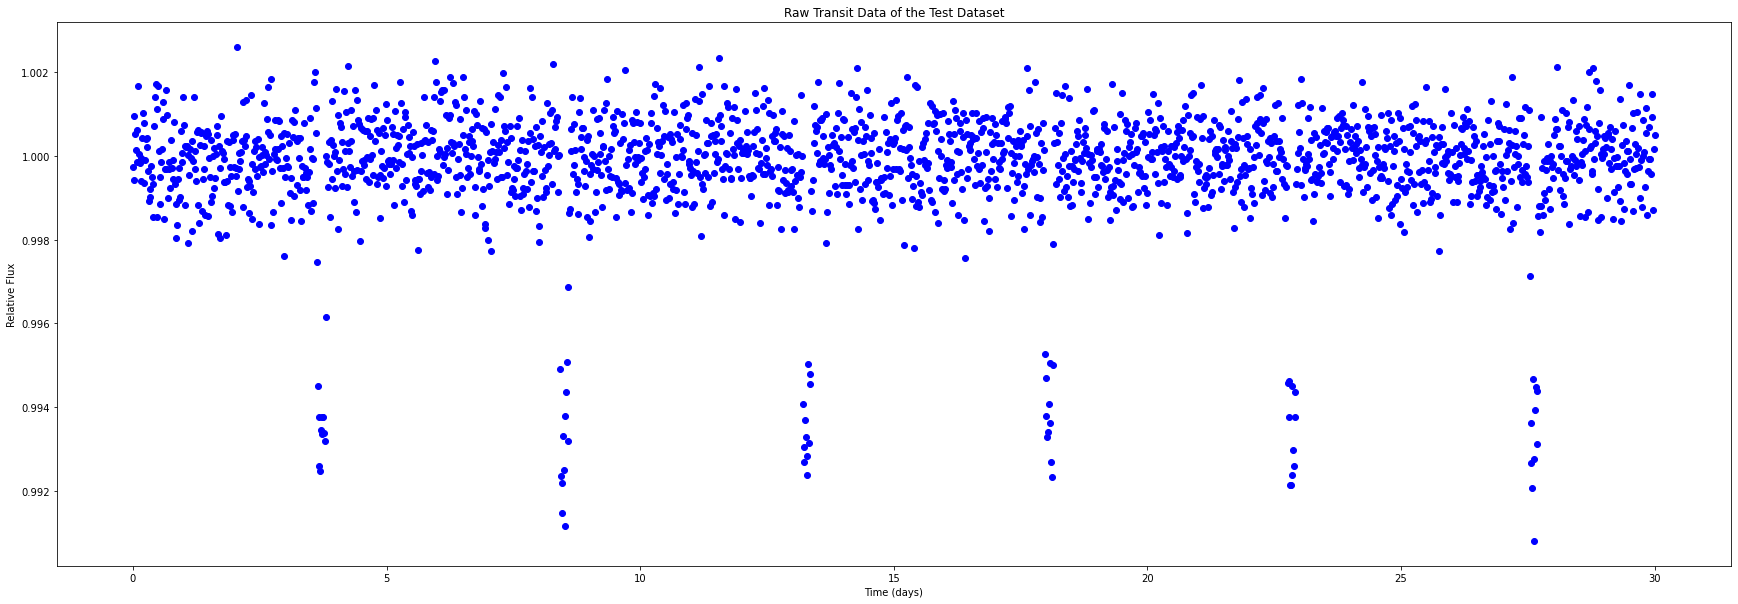

In [5]:
raw_time = []
raw_flux = []
raw_flux_err = []

for i in range(len(data)):
  raw_time.append(data[i][0])
  raw_flux.append(data[i][1])
  raw_flux_err.append(data[i][2])

raw_time = np.array(raw_time)
raw_flux = np.array(raw_flux)
raw_flux_err = np.array(raw_flux_err)

plt.figure(figsize=(30,10))
plt.title("Raw Transit Data of the Test Dataset")
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.scatter(raw_time,raw_flux,color="b")

###Writing a Function to Plot a Lightcurve from Transit Parameters

In [6]:
def transit_plot(par,t,xaxis="Time (days)",plottype="line",colour="b",transparency=None):   #creating a function to take a list parameter inputs and plot a lightcurve
  params = batman.TransitParams()
  params.t0 = par[0]                      #time of inferior conjunction
  params.per = par[1]                     #orbital period
  params.rp = par[2]                      #planet radius (in units of stellar radii)
  params.a = par[3]                       #semi-major axis (in units of stellar radii)
  params.inc = par[4]                     #orbital inclination (in degrees)
  params.ecc = par[5]                     #eccentricity
  params.w = par[6]                       #longitude of periastron (in degrees)
  params.u = [0.1, 0.3]                   #limb darkening coefficients [u1, u2]
  params.limb_dark = "quadratic"          #limb darkening model
  #m = batman.TransitModel(params, t)      #initializes model
  time_space = np.linspace(min(t),max(t),500)
  m = batman.TransitModel(params,time_space)
  flux = m.light_curve(params)            #calculates light curve
  if plottype == "scatter":
    plt.scatter(time_space,flux,color=colour,alpha=transparency)
  else:
    plt.plot(time_space,flux,color=colour,alpha=transparency)
  plt.xlabel(xaxis)
  plt.ylabel("Relative flux")

The function transit_plot takes four arguments, the first of which is a list of parameters for the BATMAN model to create a lightcurve with. This will compute flux values for plotting against a list of time values that are also passed into the function. The function can then be passed additional arguments to specify the type of plot desired and also the colour. This will be useful when plotting a model lightcurve over the raw data on the same plot.

#### Testing Plotting Function

In [7]:
test_params = [0,1,0.1,15,87,0,90]
test_t = np.linspace(-0.05,0.05,100)

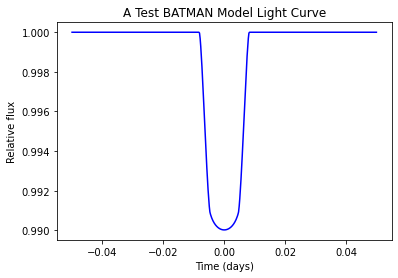

In [8]:
transit_plot(test_params,test_t)
plt.title("A Test BATMAN Model Light Curve")
plt.show()

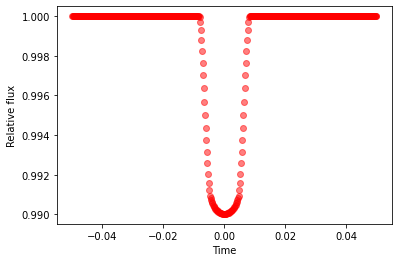

In [9]:
transit_plot(test_params,test_t,"Time","scatter","r",0.5)

##1. Manually Fitting Transit Parameters to the Raw Data

For this part of the notebook, I'll be attempting to find the parameters of the transit curve manually, by plotting curves of the raw data and trial parameters on the same plot and adjusting the parameters until they roughly line up against the raw data.

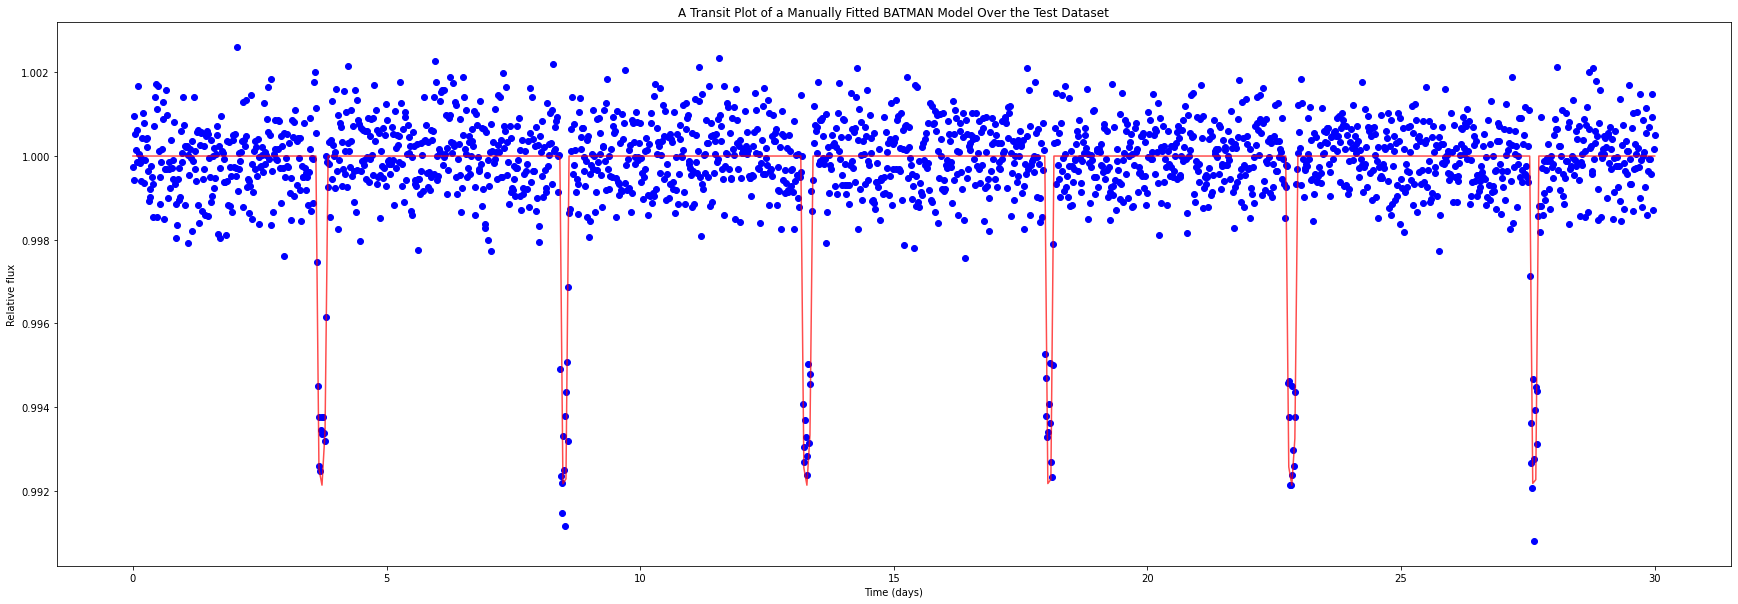

In [10]:
plt.figure(figsize=(30,10))
plt.scatter(raw_time,raw_flux,color="b")
initial_params = [3.719,4.78,0.085,10,90.5,0,90]
transit_plot(initial_params,raw_time,colour="r",transparency=0.7)
plt.title("A Transit Plot of a Manually Fitted BATMAN Model Over the Test Dataset")
plt.show()

The inital parameters I've obtained seem to fit the data roughly well, although the raw data is interesting in that each transit depth seems to be very different without any recognisable pattern.

##2. Using a Minimize Function to Find More Accurate Transit Parameters for the Raw Data

###Writing a function to Minimize the Parameters from a set of Initial Values

In order to use a minimize function to find accurate initial parameters for the raw transit data, we need to use a function that can assess the goodness of fit for each iteration of transit parameters that the minimize function will attempt to fit to the data. Then we can use this function as a parameter in the minimize function to obtain accurate transit parameters, using our initial parameters as a good starting point.

Note: For this transit I will be holding eccentricity and longitude of periastron fixed at 0 and 90 degrees respectfully.

In [11]:
def fitting(par,t,flux,flux_err): #batman parameters, fit batman model to our data
  params = batman.TransitParams()
  params.t0 = par[0]                      #time of inferior conjunction
  params.per = par[1]                     #orbital period
  params.rp = par[2]                      #planet radius (in units of stellar radii)
  params.a = par[3]                       #semi-major axis (in units of stellar radii)
  params.inc = par[4]                     #orbital inclination (in degrees)
  params.ecc = 0                          #eccentricity
  params.w = 90                           #longitude of periastron (in degrees)
  params.u = [0.1, 0.3]                   #limb darkening coefficients [u1, u2]
  params.limb_dark = "quadratic" 
  LC_model = batman.TransitModel(params, t)
  LC_flux = LC_model.light_curve(params)  #calulating lightcurve flux values from input parameters
  return 0.5 * np.nansum(((LC_flux - flux)**2)/flux_err**2) #return a value for goodness of fit of the calculated lightcurve using input parameters against the raw data

####Testing Goodness of Fit Function with Initial Values from Section 1

In [12]:
initial_fit = fitting(initial_params,raw_time,raw_flux,raw_flux_err)
print(initial_fit)

1196.5982395872975


We get a goodness of fit value of 1196 for our initial parameters that we manually fitted, we don't know if this is good or bad but the minimize function will try to get this value as small as it can.

###Using a Minimize Function the Fitting Function

In [13]:
input_params = initial_params[:5]
print("The initial parameters are:")
print(input_params)

args = (raw_time,raw_flux,raw_flux_err)
minimize_output = minimize(fitting,input_params,args,method = 'Nelder-Mead')
print(minimize_output)

The initial parameters are:
[3.719, 4.78, 0.085, 10, 90.5]
 final_simplex: (array([[3.71762829e+00, 4.78070560e+00, 7.97779596e-02, 8.14755274e+00,
        9.31147956e+01],
       [3.71762834e+00, 4.78070560e+00, 7.97780382e-02, 8.14750281e+00,
        9.31148933e+01],
       [3.71762833e+00, 4.78070560e+00, 7.97779653e-02, 8.14755133e+00,
        9.31147955e+01],
       [3.71762837e+00, 4.78070559e+00, 7.97779966e-02, 8.14753102e+00,
        9.31148425e+01],
       [3.71762840e+00, 4.78070557e+00, 7.97779597e-02, 8.14756178e+00,
        9.31147789e+01],
       [3.71762837e+00, 4.78070558e+00, 7.97779775e-02, 8.14750604e+00,
        9.31148841e+01]]), array([1079.85931599, 1079.85931599, 1079.85931599, 1079.85931599,
       1079.85931599, 1079.85931599]))
           fun: 1079.859315987147
       message: 'Optimization terminated successfully.'
          nfev: 680
           nit: 423
        status: 0
       success: True
             x: array([3.71762829e+00, 4.78070560e+00, 7.97779596

In [14]:
minimize_params = minimize_output.x
ecc_w = np.array([0,90])
final_params = np.append(minimize_params,ecc_w)

print("The initial parameters were:")
print(initial_params)
print("The goodness of fit was:")
print(initial_fit)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("The final parameters are:")
print(final_params)
print("The goodness of fit is:")
new_fit = fitting(final_params,raw_time,raw_flux,raw_flux_err)
print(new_fit)

The initial parameters were:
[3.719, 4.78, 0.085, 10, 90.5, 0, 90]
The goodness of fit was:
1196.5982395872975
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The final parameters are:
[3.71762829e+00 4.78070560e+00 7.97779596e-02 8.14755274e+00
 9.31147956e+01 0.00000000e+00 9.00000000e+01]
The goodness of fit is:
1079.859315987147


As we can see, the value for the goodness of fit from the parameters that are found after minimizing the function is lower than the initial parameters, so they are much more accurate for fitting to the data.

###Comparing the Minimized Parameters to the Raw Data

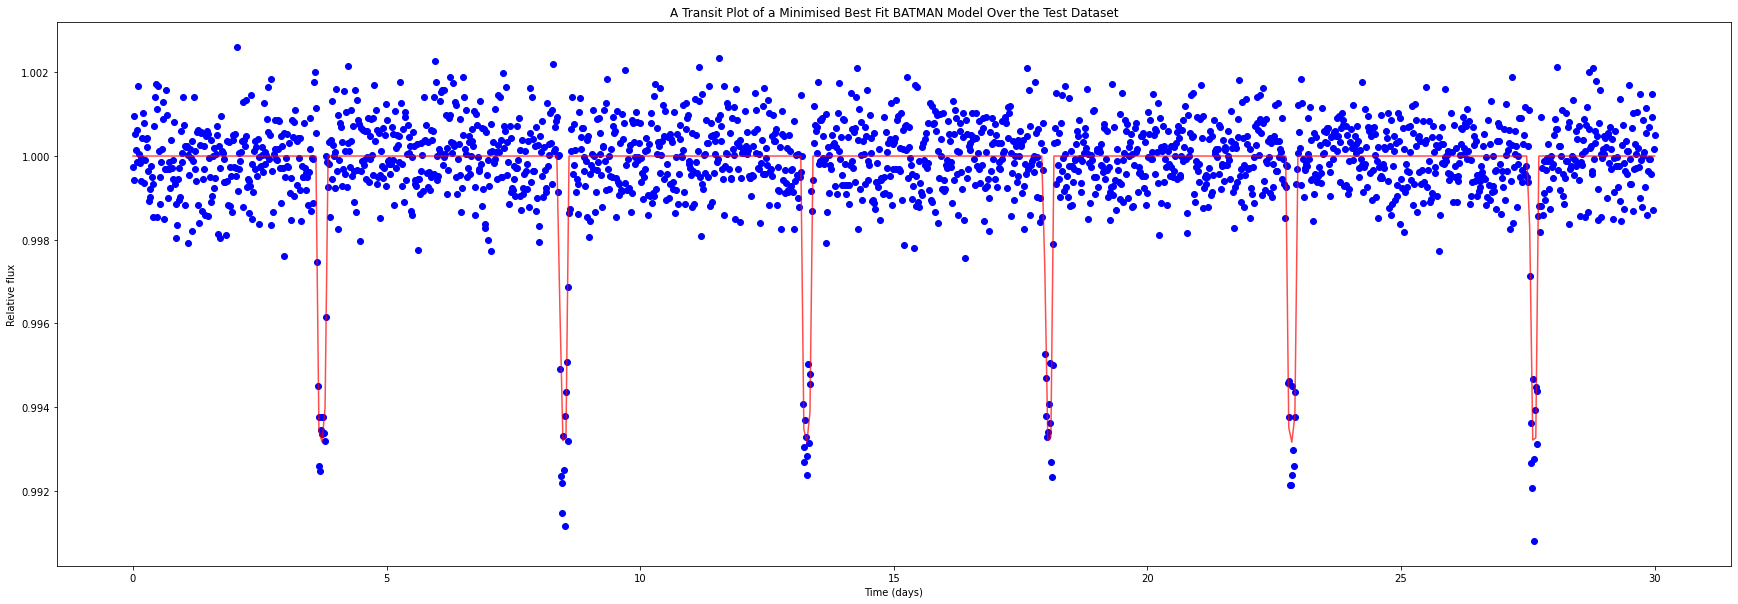

In [15]:
plt.figure(figsize=(30,10))
plt.scatter(raw_time,raw_flux,color="b")
transit_plot(final_params,raw_time,colour="r",transparency=0.7)
plt.title("A Transit Plot of a Minimised Best Fit BATMAN Model Over the Test Dataset")
plt.show()

## Folding the Data to Plot in Phase

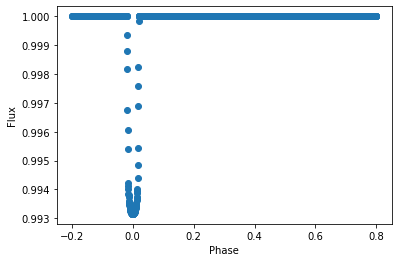

In [16]:
phase = np.mod(raw_time-final_params[0], final_params[1]) / final_params[1]
phase[phase>0.8] -= 1
params = batman.TransitParams()
params.t0 = final_params[0]                      #time of inferior conjunction
params.per = final_params[1]                     #orbital period
params.rp = final_params[2]                      #planet radius (in units of stellar radii)
params.a = final_params[3]                       #semi-major axis (in units of stellar radii)
params.inc = final_params[4]                     #orbital inclination (in degrees)
params.ecc = final_params[5]                     #eccentricity
params.w = final_params[6]                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                            #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"                   #limb darkening model
final_model = batman.TransitModel(params, raw_time)     #initializes model
final_flux = final_model.light_curve(params)               #calculates light curve
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.scatter(phase,final_flux)

#Part 2: Analysing Follow-up Data and Assessing Uncertainties

This part of the notebook will follow the analysis of a second dataset of the same exoplanet transit, this follow-up data simulates the kind of data that the Hubble telescope would collect when pointed at a transiting exoplanet. I will first manually find initial parameters for the data using the BATMAN model, and then use a Marcov-Chain-Monte-Carlo function to find the optimal parameters for the transit along with their assosiated errors. I will also revisit the initial raw data and perform the same function with the aim to compare the datasets and assess whether or not the data is significantly different. 

##Manually Fitting Parameters to the Follow-up Dataset

In [17]:
followup_data = ascii.read("https://raw.githubusercontent.com/Hamza-Suleman/transiting-exoplanets/main/Transit_model_LC_follow-up_data.txt?token=GHSAT0AAAAAABQXVTRVHRHLZE3NC6VLIXROYPRN2MQ")
print(followup_data)

  time    flux  flux_err
------- ------- --------
   3.58 1.00002   0.0001
3.58008 1.00005  0.00012
3.58016 1.00004  0.00012
3.58024 0.99988    8e-05
3.58032 0.99989  0.00011
 3.5804 1.00009  0.00012
3.58048 0.99991    8e-05
3.58056 0.99973    8e-05
3.58064 1.00014    8e-05
3.58072 1.00002   0.0001
    ...     ...      ...
 3.8792 1.00003    8e-05
3.87928 0.99991  0.00011
3.87936 0.99987  0.00011
3.87944 0.99993    8e-05
3.87952 0.99998    8e-05
 3.8796 0.99998    9e-05
3.87968 0.99987   0.0001
3.87976 1.00023    8e-05
3.87984 1.00006    8e-05
3.87992 0.99992    9e-05
   3.88  1.0001  0.00011
Length = 2000 rows


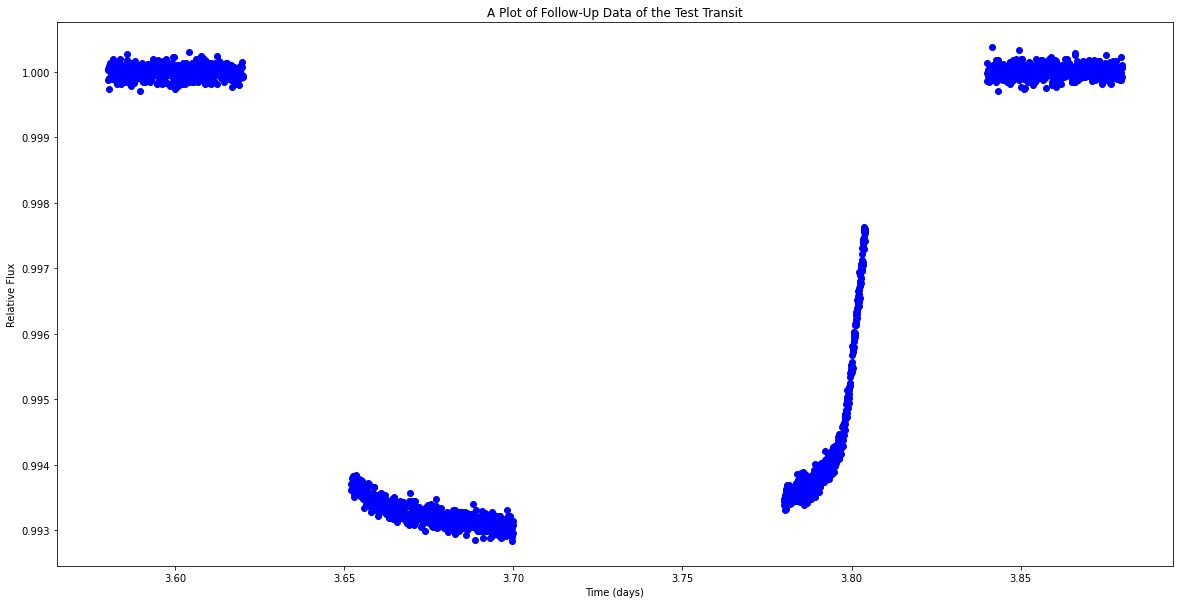

In [18]:
followup_time = []
followup_flux = []
followup_flux_err = []

for i in range(len(followup_data)):
  followup_time.append(followup_data[i][0])
  followup_flux.append(followup_data[i][1])
  followup_flux_err.append(followup_data[i][2])

followup_time = np.array(followup_time)
followup_flux = np.array(followup_flux)
followup_flux_err = np.array(followup_flux_err)

plt.figure(figsize=(20,10))
plt.scatter(followup_time,followup_flux,color="b")
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("A Plot of Follow-Up Data of the Test Transit")
plt.show()

Why are there gaps?
This follow-up dataset simulates data that would be recorded by the hubble space telescope, the gaps are where the Earth is between the telescope and the exoplanet system we're observing.

Below I'll be attempting to find initial parameters for this follow-up data set by manually fitting a BATMAN model to it.

Note: I'll be keeping eccentricity and longitude of perisastron fixed as well as orbital period, which we cannot find from this dataset as there is only one transit given.

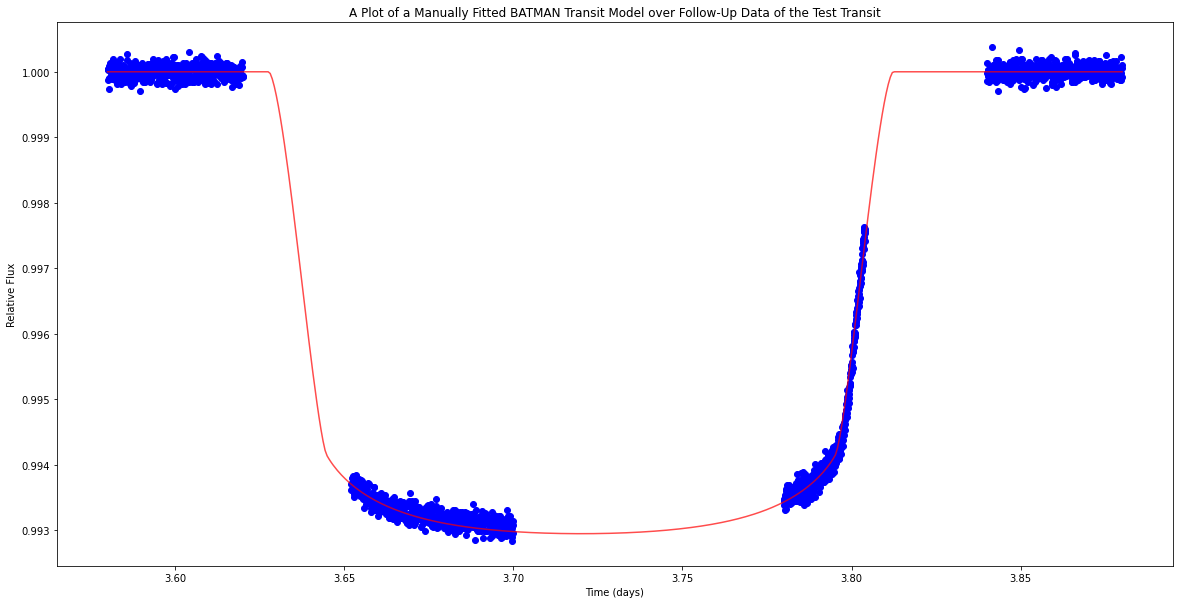

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(followup_time,followup_flux,color="b")
followup_initial_params = [3.72e+00,4.78070560e+00,8.1e-02,8.16e+00,9.31147956e+01,0.00000000e+00,9.00000000e+01]
transit_plot(followup_initial_params,followup_time,colour="r",transparency=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("A Plot of a Manually Fitted BATMAN Transit Model over Follow-Up Data of the Test Transit")
plt.show()

##Creating Functions for MCMC Analysis

We will be using the MCMC to find optimal values for: time of inferior conjuction t0, planet radius rp, semi major axis a, and inclination inc. Orbital period cant be found with this data, and we will be keeping ecc and longitude of periastron fixed at 0 and 90.

In [20]:
def log_likelihood(par, t, flux, flux_error):
  params = batman.TransitParams()
  params.t0 = par[0]                      #time of inferior conjunction
  params.per = 4.78070560                 #orbital period
  params.rp = par[1]                      #planet radius (in units of stellar radii)
  params.a = par[2]                       #semi-major axis (in units of stellar radii)
  params.inc = par[3]                     #orbital inclination (in degrees)
  params.ecc = 0                          #eccentricity
  params.w = 90                           #longitude of periastron (in degrees)
  params.u = [0.1, 0.3]                   #limb darkening coefficients [u1, u2]
  params.limb_dark = "quadratic" 
  LC_model = batman.TransitModel(params, t)
  LC_flux = LC_model.light_curve(params)  #calulating lightcurve flux values from input parameters
  return -0.5 * np.nansum(((LC_flux - flux)**2)/flux_error**2) #return log likelihood

In [21]:
def log_prior(par):
    #print(par)
    if par[0] > 0 and 0 < par[1] < 1 and par[2] > 0 and 0 < par[3] < 90: #these are limits we know to be true for the parameters that we have
        return 0.0
    #print("inf")
    return -np.inf

In [22]:
def log_probability(par, t, flux, flux_error):
    lp = log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(par, t, flux, flux_error)

In [23]:
def MCMC(par, t, flux, flux_error):
  pos = par + 1e-4 * np.random.randn(50, 4)
  nwalkers, ndim = pos.shape

  sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(t, flux, flux_error)
  )
  sampler.run_mcmc(pos, 5000, progress=True);
  
  samples = sampler.get_chain()
  fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
  labels = ["t0", "rp", "a","inc"]
  for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

  axes[-1].set_xlabel("step number");

  params = np.zeros((4,3))

  flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
  print("These are the variables calculated by MCMC analysis:")
  for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    params[i] = (mcmc[1], q[0], q[1])

  return flat_samples,params

##Applying a MCMC to the Follow-up Data

100%|██████████| 5000/5000 [01:31<00:00, 54.47it/s]


These are the variables calculated by MCMC analysis:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

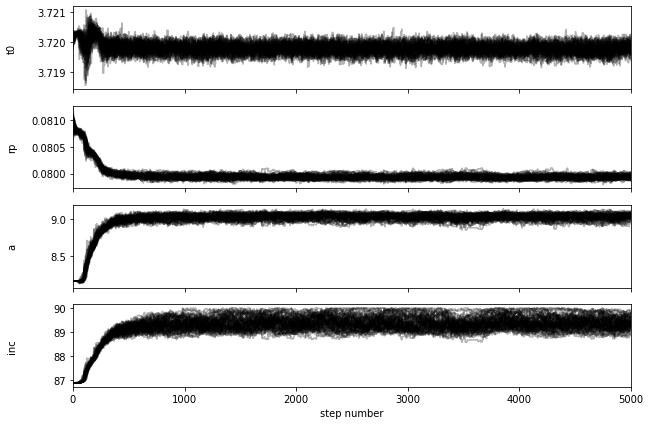

In [24]:
followup_input_params = [followup_initial_params[0],followup_initial_params[2],followup_initial_params[3],90-(followup_initial_params[4]-90)]
followup_input_params = np.array(followup_input_params)
#print(followup_input_params)

followup_mcmc_output = MCMC(followup_input_params,followup_time,followup_flux,followup_flux_err)
followup_flat_samples = followup_mcmc_output[0]
followup_mcmc_params = followup_mcmc_output[1]

In [25]:
print(followup_mcmc_params)

[[3.71977554e+00 1.61303497e-04 1.67541351e-04]
 [7.99286671e-02 3.95051825e-05 4.73015118e-05]
 [9.03859037e+00 4.68395077e-02 3.71288504e-02]
 [8.93467014e+01 2.64187577e-01 3.45458388e-01]]


In [26]:
folloup_fitted_params = [3.71977746e+00,4.78070560,7.99279488e-02,9.04106319e+00,8.93625804e+01,0,90]

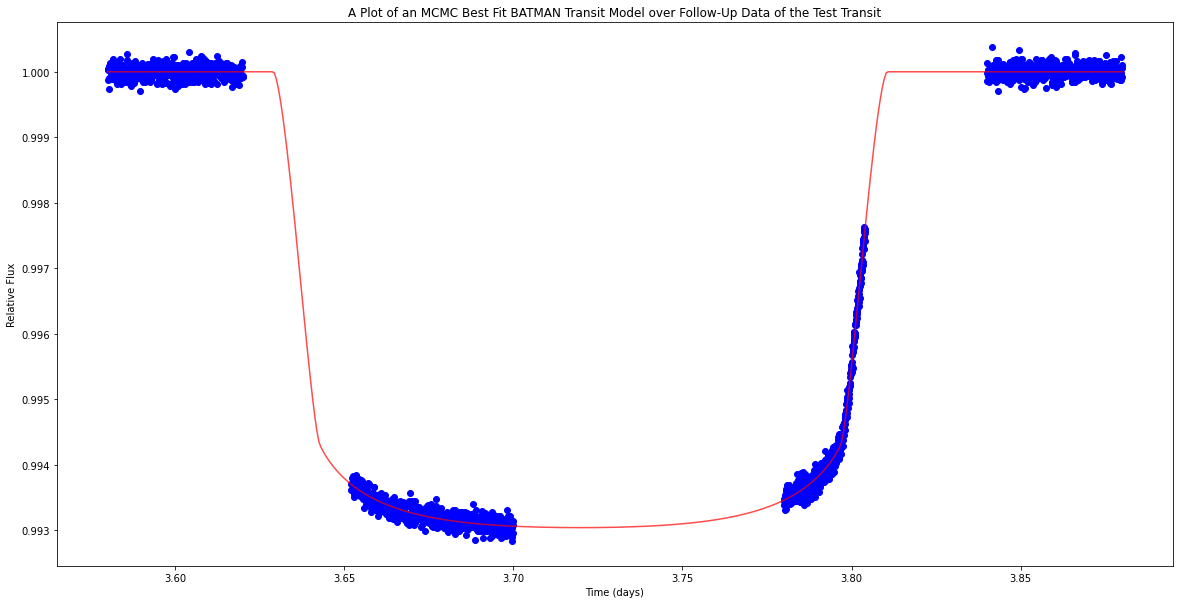

In [27]:
plt.figure(figsize=(20,10))
plt.scatter(followup_time,followup_flux,color="b")
transit_plot(folloup_fitted_params,followup_time,colour="r",transparency=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("A Plot of an MCMC Best Fit BATMAN Transit Model over Follow-Up Data of the Test Transit")
plt.show()

## Applying a MCMC to the Initial Dataset

100%|██████████| 5000/5000 [00:58<00:00, 85.26it/s]


These are the variables calculated by MCMC analysis:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

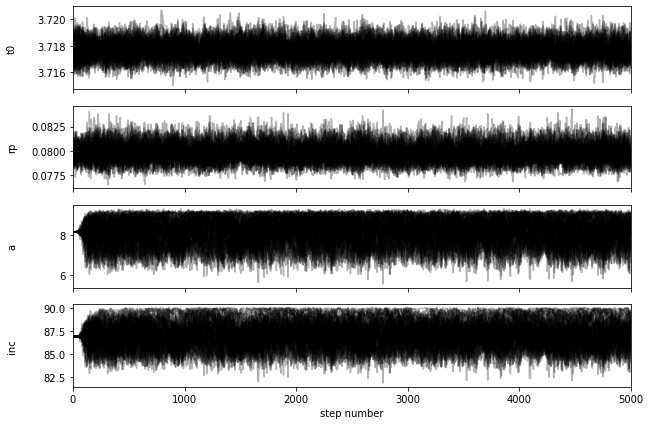

In [28]:
final_input_params = [final_params[0],final_params[2],final_params[3],90-(final_params[4]-90)]
final_input_params = np.array(final_input_params)
#print(final_input_params)
initial_mcmc_output = MCMC(final_input_params,raw_time,raw_flux,raw_flux_err)
final_flat_samples = initial_mcmc_output[0]
final_mcmc_params = initial_mcmc_output[1]

Note: For the initial dataset, i used the minimised parameters, and the MCMC required almost no burn in at all.

In [29]:
print(final_mcmc_params)

[[3.71763869e+00 6.06530856e-04 6.58603553e-04]
 [7.96923316e-02 7.96534726e-04 9.35896806e-04]
 [8.28254421e+00 7.95894819e-01 6.60956481e-01]
 [8.71657832e+01 1.48275474e+00 1.69683631e+00]]


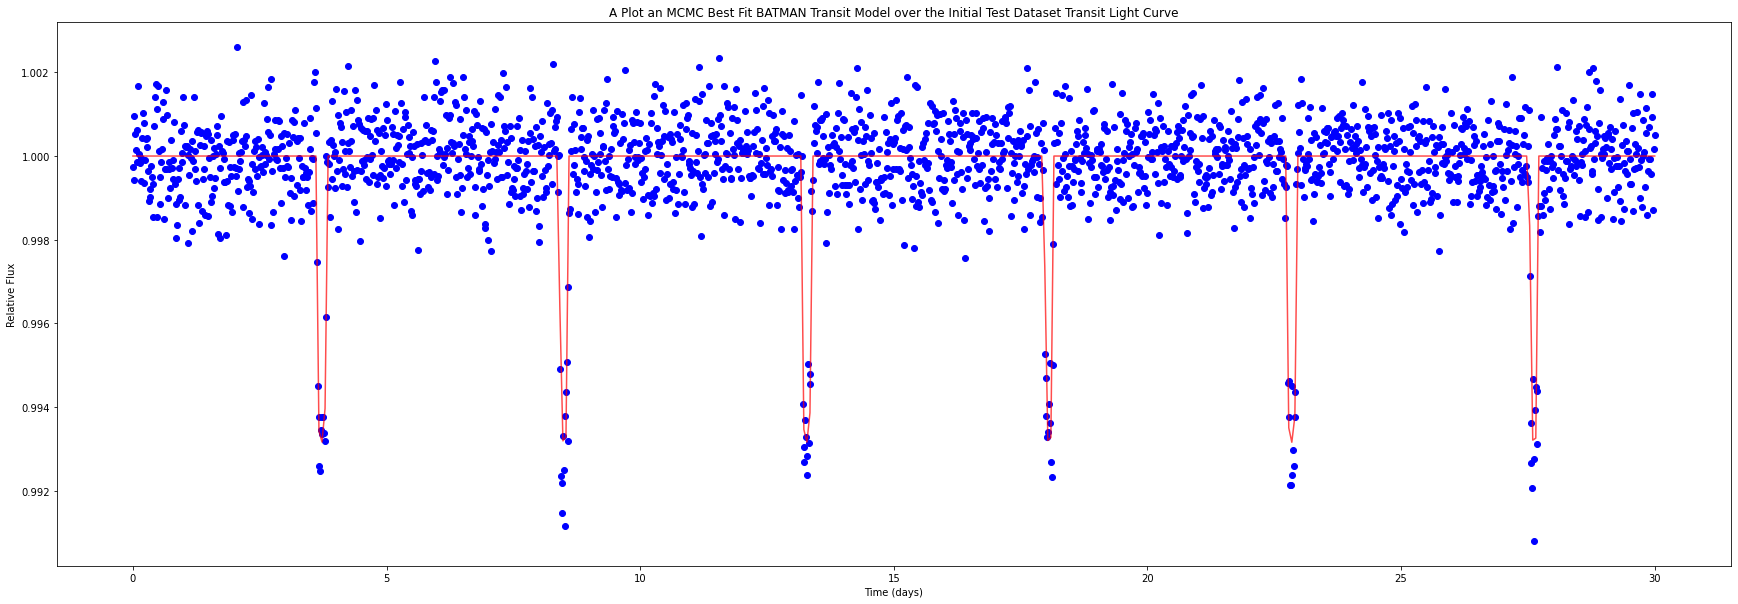

In [30]:
initial_fitted_params = [3.71764796e+00,4.78070560,7.96965210e-02,8.27088623e+00,8.71331232e+01,0,90]
plt.figure(figsize=(30,10))
plt.scatter(raw_time,raw_flux,color="b")
transit_plot(initial_fitted_params,raw_time,colour="r",transparency=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Relative Flux")
plt.title("A Plot an MCMC Best Fit BATMAN Transit Model over the Initial Test Dataset Transit Light Curve")
plt.show()

##Do the Parameters From the Initial and Follow-up Data Agree Within 3-Sigmas?

In [31]:
'''

#3-sigma tests

print("3-sigma test for t0:")
t0_diff = abs((initial_t0[0]-followup_t0[0])/initial_t0[1])
print(t0_diff)
if t0_diff < 3:
  print("Agrees")
else:
  print("Does not agree")

print("3-sigma test for rp:")
rp_diff = abs((initial_rp[0]-followup_rp[0])/initial_rp[1])
print(rp_diff)
if rp_diff < 3:
  print("Agrees")
else:
  print("Does not agree")

print("3-sigma test for a:")
a_diff = abs((initial_a[0]-followup_a[0])/initial_a[1])
print(a_diff)
if a_diff < 3:
  print("Agrees")
else:
  print("Does not agree")

print("3-sigma test for inc:")
inc_diff = abs((initial_inc[0]-followup_inc[0])/initial_inc[1])
print(inc_diff)
if inc_diff < 3:
  print("Agrees")
else:
  print("Does not agree")

'''

'\n\n#3-sigma tests\n\nprint("3-sigma test for t0:")\nt0_diff = abs((initial_t0[0]-followup_t0[0])/initial_t0[1])\nprint(t0_diff)\nif t0_diff < 3:\n  print("Agrees")\nelse:\n  print("Does not agree")\n\nprint("3-sigma test for rp:")\nrp_diff = abs((initial_rp[0]-followup_rp[0])/initial_rp[1])\nprint(rp_diff)\nif rp_diff < 3:\n  print("Agrees")\nelse:\n  print("Does not agree")\n\nprint("3-sigma test for a:")\na_diff = abs((initial_a[0]-followup_a[0])/initial_a[1])\nprint(a_diff)\nif a_diff < 3:\n  print("Agrees")\nelse:\n  print("Does not agree")\n\nprint("3-sigma test for inc:")\ninc_diff = abs((initial_inc[0]-followup_inc[0])/initial_inc[1])\nprint(inc_diff)\nif inc_diff < 3:\n  print("Agrees")\nelse:\n  print("Does not agree")\n\n'

It seems that we have agreement for three out of the four paramaters, only the t0 value doesn't agree, but this could be due to the fact that it has such a low error in the first place.

##Do the Parameterrs Agree? (Histograms)

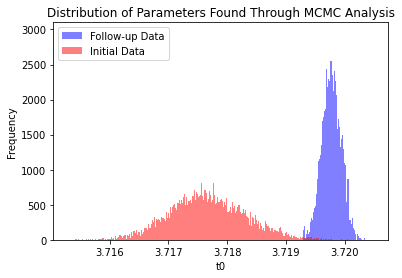

Do they Agree?
Yes


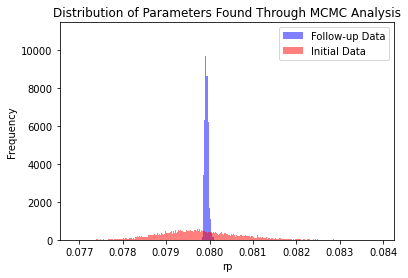

Do they Agree?
Yes


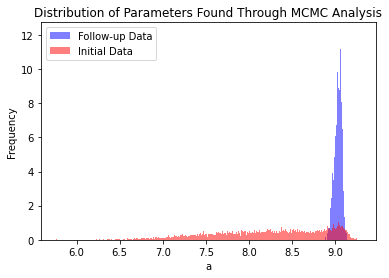

Do they Agree?
Yes


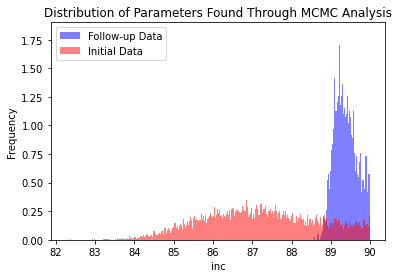

Do they Agree?
Yes


In [32]:
labels = ["t0", "rp", "a","inc"]
for i in range(len(followup_flat_samples[0,:])):
  kwargs = dict(alpha=0.5, bins=500, density=True, stacked=True)
  plt.hist(followup_flat_samples[:,i],**kwargs, color='b', label='Follow-up Data')
  plt.hist(final_flat_samples[:,i],**kwargs, color='r', label='Initial Data')
  plt.gca().set(title='Distribution of Parameters Found Through MCMC Analysis',ylabel="Frequency",xlabel=labels[i])
  plt.legend()
  plt.show()
  print("Do they Agree?")
  if followup_mcmc_params[i,0] > final_mcmc_params[i,0]:
    if followup_mcmc_params[i,0] + (final_mcmc_params[i,2]*3) > followup_mcmc_params[i,0]:
      print("Yes")
    else:
      print("No")
  elif followup_mcmc_params[i,0] < final_mcmc_params[i,0]:
    if followup_mcmc_params[i,0] - (final_mcmc_params[i,1]*3) < followup_mcmc_params[i,0]:
      print("Yes")
    else:
      print("No")